# QA Agent

In [14]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import (
    AutoModelForQuestionAnswering, 
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

# Set device to MPS (Apple Silicon GPU) if available, otherwise use CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [2]:
qa_data = [
    ("The Eiffel Tower is located in Paris, France.", "Where is the Eiffel Tower?", "Paris, France"),
    ("Albert Einstein developed the theory of relativity.", "Who developed the theory of relativity?", "Albert Einstein"),
    ("Python is a programming language used for web development, data science, and AI.", "What is Python used for?", "Web development, data science, and AI"),
    ("The Amazon Rainforest is home to over 10 million species of animals and plants.", "What is the Amazon Rainforest home to?", "Over 10 million species of animals and plants"),
    ("The Great Wall of China was built to protect against invasions.", "Why was the Great Wall of China built?", "To protect against invasions")
]

In [3]:
df = pd.DataFrame(qa_data, columns=["context", "question", "answer"])

In [4]:
model_name = "deepset/roberta-base-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Move model to the correct device
model.to(device)

RobertaForQuestionAnswering(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              

In [5]:
def preprocess_function(examples):
    return tokenizer(
        examples["question"], examples["context"],
        truncation=True, padding="max_length", max_length=384,
        return_tensors="pt"
    )

In [6]:
qa_dataset = Dataset.from_pandas(df)

In [7]:
def add_labels(example):
    inputs = tokenizer(
        example["question"], example["context"],
        truncation=True, padding="max_length", max_length=384,
        return_offsets_mapping=True  # This returns character index mappings
    )

    # Extract answer
    answer = example["answer"]
    start_char = example["context"].find(answer)
    end_char = start_char + len(answer) - 1  # Subtract 1 to avoid off-by-one errors

    # Find corresponding token positions
    offsets = inputs["offset_mapping"]
    start_positions = None
    end_positions = None

    for idx, (start, end) in enumerate(offsets):
        if start <= start_char < end:  # Check if token contains start_char
            start_positions = idx
        if start <= end_char < end:  # Check if token contains end_char
            end_positions = idx
            break  # Stop once we find the end

    # If start_positions or end_positions is None, set them to CLS token (index 0)
    if start_positions is None or end_positions is None:
        start_positions = 0  # CLS token index
        end_positions = 0

    # Add start and end positions to the inputs
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    # Remove offset mapping before returning (we don't need it in training)
    del inputs["offset_mapping"]

    return inputs


In [8]:
tokenized_dataset = qa_dataset.map(add_labels)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [9]:
training_args = TrainingArguments(
    output_dir="./results",              # Directory to save model checkpoints
    eval_strategy="epoch",         # Evaluate at the end of each epoch
    per_device_train_batch_size=2,       # Training batch size per device
    per_device_eval_batch_size=2,        # Evaluation batch size per device
    num_train_epochs=3,                   # Number of epochs
    save_steps=1000,                      # Save every 1000 steps
    logging_dir="./logs",                 # Directory for logs
)

In [10]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,  # Normally, you should use a separate validation dataset
    processing_class=tokenizer,
    data_collator=data_collator
)

In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,2.225821
2,No log,1.173933
3,No log,0.982020


TrainOutput(global_step=9, training_loss=2.8306827545166016, metrics={'train_runtime': 5.7675, 'train_samples_per_second': 2.601, 'train_steps_per_second': 1.56, 'total_flos': 2939588513280.0, 'train_loss': 2.8306827545166016, 'epoch': 3.0})

In [13]:
def answer_question(question, context):
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to MPS
    
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the predicted answer span
    answer_start = torch.argmax(outputs.start_logits)
    answer_end = torch.argmax(outputs.end_logits) + 1
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))

    return answer

# Example Test
context = "The Eiffel Tower is located in Paris, France."
question = "Where is the Eiffel Tower?"
answer = answer_question(question, context)
print(f"Question: {question}")
print(f"Predicted Answer: {answer}")


Question: Where is the Eiffel Tower?
Predicted Answer:  Paris, France


In [15]:

def plot_confidence_scores(question, context):
    # Tokenize and move inputs to MPS
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Get model outputs
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities
    start_probs = torch.nn.functional.softmax(outputs.start_logits, dim=-1).cpu().numpy().flatten()
    end_probs = torch.nn.functional.softmax(outputs.end_logits, dim=-1).cpu().numpy().flatten()

    # Get tokenized words for plotting
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0].cpu().numpy())

    # Plot Start and End Probabilities
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(tokens)), start_probs, label="Start Probabilities", color="blue")
    plt.plot(range(len(tokens)), end_probs, label="End Probabilities", color="red")
    plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=8)  # Show tokens as labels
    plt.xlabel("Token Index")
    plt.ylabel("Probability")
    plt.title(f"Confidence Scores for '{question}'")
    plt.legend()
    plt.show()

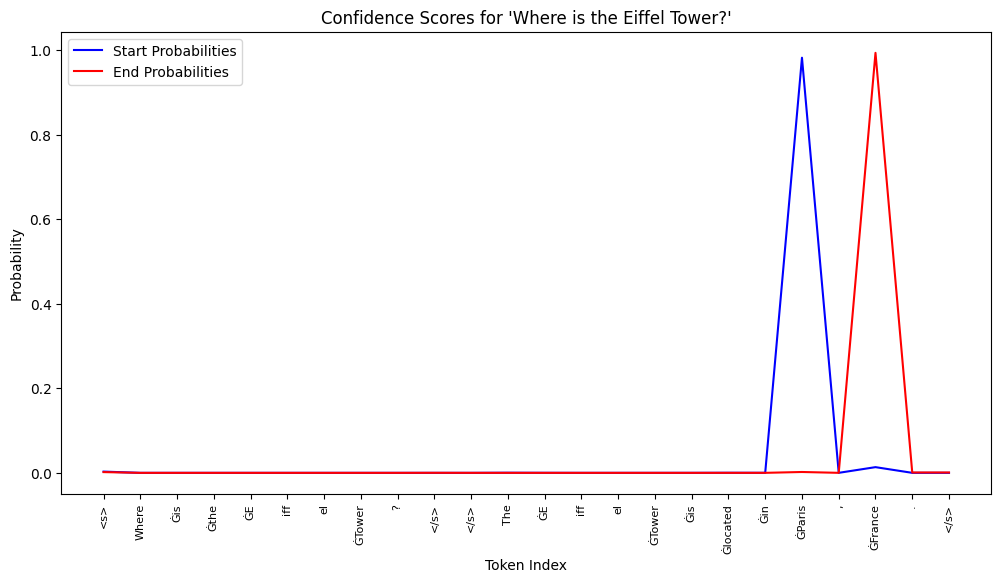

In [16]:
context = "The Eiffel Tower is located in Paris, France."
question = "Where is the Eiffel Tower?"
plot_confidence_scores(question, context)